<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/DL_final_Part2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -q openslide-tools
!pip install openslide-python

Reading package lists...
Building dependency tree...
Reading state information...
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


In [0]:
!pip install -q tensorflow-gpu==2.0.0-alpha0

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os 
from PIL import Image
from skimage.color import rgb2gray
import random
import tensorflow as tf
import numpy as np

In [5]:
print(tf.__version__)

2.0.0-alpha0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [6]:
import os, re
path_slides = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
slides = list(filter(lambda filename: re.match("tumor_[0-9]*\.tif", filename), os.listdir(path_slides)))
masks = list(filter(lambda filename: re.match("tumor_[0-9]*_mask\.tif", filename), os.listdir(path_slides)))
slides = sorted(slides)
masks =sorted(masks)
# tumor_038_mask.tif is missing
slides.remove('tumor_038.tif')
print("total slides {} total masks {}".format(len(slides), len(masks)))
["{} || {}".format(slide, mask) for slide, mask in zip(slides, masks)]

total slides 21 total masks 21


['tumor_001.tif || tumor_001_mask.tif',
 'tumor_002.tif || tumor_002_mask.tif',
 'tumor_005.tif || tumor_005_mask.tif',
 'tumor_012.tif || tumor_012_mask.tif',
 'tumor_016.tif || tumor_016_mask.tif',
 'tumor_019.tif || tumor_019_mask.tif',
 'tumor_023.tif || tumor_023_mask.tif',
 'tumor_031.tif || tumor_031_mask.tif',
 'tumor_035.tif || tumor_035_mask.tif',
 'tumor_057.tif || tumor_057_mask.tif',
 'tumor_059.tif || tumor_059_mask.tif',
 'tumor_064.tif || tumor_064_mask.tif',
 'tumor_075.tif || tumor_075_mask.tif',
 'tumor_078.tif || tumor_078_mask.tif',
 'tumor_081.tif || tumor_081_mask.tif',
 'tumor_084.tif || tumor_084_mask.tif',
 'tumor_091.tif || tumor_091_mask.tif',
 'tumor_094.tif || tumor_094_mask.tif',
 'tumor_096.tif || tumor_096_mask.tif',
 'tumor_101.tif || tumor_101_mask.tif',
 'tumor_110.tif || tumor_110_mask.tif']

In [0]:
# slide paths and masks path
slide_paths = [os.path.join(path_slides, slide) for slide in slides]
mask_paths = [os.path.join(path_slides, mask) for mask in masks]

In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def deep_scan(slide, mask, x, y, s, m, width=50, height=50, lv=0):
  if not slide or not mask:
    print('feed in slide and mask object(openslide object)\n')
    return
  ALL_LEVEL = 8
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = None
  print('slide width (x-axis) {}  || depth (y-axis) {} || channel {}'.format(s.shape[1], s.shape[0], s.shape[2])) # if you use np.shape, remember to swap
  print('mask  width (x-axis) {}  || depth (y-axis) {} ||'.format(m.shape[1], m.shape[0]))
  print('deep scan at coordinate: ({:<5} (x-axis), {:<5} (y-aixs))\n'.format(x, y))
  
  # s and m are already np array, not the open-slide object
  if m[y][x]:
    print('this pixel is marked as tumor', '[positive]')
  else:
    print('this pixel is not marked as tumor', '[negative]')
   
  # scan all levels for a (width * height) image
  for i in range(0, ALL_LEVEL):
    plt.subplot(2, 4, i + 1)
    region = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=i, width=width, height=height)
    if i == lv: path = region
    plt.imshow(region)
  
  return patch
  
def get_patch(slide, mask, x, y, width=50, height=50, lv=0):
  if not slide or not mask:
    print('feed in slide and mask object(openslide object)\n')
    return
  ALL_LEVEL = 8
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=lv, width=width, height=height)
  return patch

def find_tumor_pixels(m):
  return [(j, i) for i, row in enumerate(m)
              for j, c in enumerate(row) if c]

# s: the tumor image at some level
# intensity: threshold to filter the image
def find_tissue_pixels(s, intensity=0.8):
  s_gray = rgb2gray(s)
  idx = np.where(s_gray <= intensity)
  return zip(idx[1], idx[0])

def print_slide(slide_name=None, mask_name=None):
  if not slide_name and not mask_name: return
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  if slide_name:
    slide_path = os.path.join(path, slide_name)
    slide = open_slide(slide_path)
    s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
    
  if mask_name:
    mask_path = os.path.join(path, mask_name)
    mask = open_slide(mask_path)
    m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]
  
  plt.figure(figsize=(4, 4), dpi=100)
  if slide_name:
    plt.imshow(s)
    plt.title(slide_path.split('/')[-1])
  if mask_name:
    plt.imshow(m, cmap='jet', alpha=0.5)
  if slide_name and mask_name:
    loc_tissue = list(find_tissue_pixels(s, 0.8))
    loc_tumor = find_tumor_pixels(m)
    print('{:20} || tissue {:10}  ||  tumor {:10} ({:2f}%)'.format(slide_path.split('/')[-1], len(loc_tissue), len(loc_tumor), 100 * len(loc_tumor)/len(loc_tissue)))

def _get_helper(slide_name, mask_name):
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  slide, mask = open_slide(slide_path), open_slide(mask_path)
  s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
  m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]  
  return slide, mask, s, m
def _get_info(slide_name, mask_name):
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  loc_tissue = list(find_tissue_pixels(s, 0.8))
  loc_tumor = find_tumor_pixels(m)
  print('{:20} || tissue {:10}  ||  tumor {:10} ({:2f}%)'.format(slide_path.split('/')[-1], len(loc_tissue), len(loc_tumor), 100 * len(loc_tumor)/len(loc_tissue)))

def _get_locs(slide_name, mask_name):
  """loc_tissue, loc_tumor, loc_normal"""
  slide, mask, s, m = _get_helper(slide_name, mask_name)
  path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
  slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
  loc_tissue = list(find_tissue_pixels(s, 0.8))
  loc_tissue = set(loc_tissue)
  loc_tumor = find_tumor_pixels(m)
  loc_tumor = set(loc_tumor)
  loc_normal = loc_tissue - loc_tumor
  return loc_tissue, loc_tumor, loc_normal





In [0]:
def get_patch2(slide, x, y, width=299, height=299, lv=0):
  mapping_factor = 128 # mapping (x, y) to the (X, Y) at level 0
  patch = read_slide(slide, x=x * mapping_factor, y=y * mapping_factor, level=lv, width=width, height=height)
  return patch

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and Validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
  plt.show()

**add training data tumor_078.tif**

tumor_078.tif        || tissue     215836  ||  tumor      59291 (27.470394%)


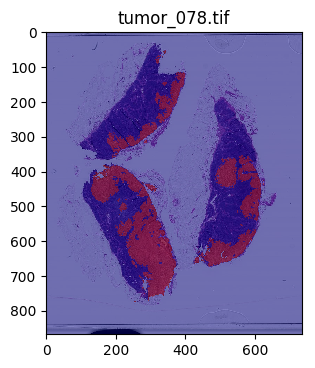

In [10]:
print_slide('tumor_078.tif', 'tumor_078_mask.tif')
path = '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/slides'
slide_name, mask_name = 'tumor_078.tif', 'tumor_078_mask.tif'
slide_path, mask_path = os.path.join(path, slide_name), os.path.join(path, mask_name)
slide, mask = open_slide(slide_path), open_slide(mask_path)
s = read_slide(slide, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])
m = read_slide(mask, x=0, y=0, level=7, width=slide.level_dimensions[7][0], height=slide.level_dimensions[7][1])[:,:,0]  

**load the previous model**

In [11]:
#os.path.exists('/content/gdrive/My Drive/DeepLearning/datasets/model_first.h5')
!cp '/content/gdrive/My Drive/DeepLearning/datasets/model_first.h5' model_first.h5
model = tf.keras.models.load_model('model_first.h5')
model.summary()
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 33,554,945
Trainable params: 33,554,945
Non-trainable params: 0
_________________________________________________________________


*The current training data will  be 20 times larger compared with the previous training data, and can not fit into the memory at once. I could build a generator or split the traning set manually. The previous data size is 5848.*

In [12]:
_get_info('tumor_091.tif', 'tumor_091_mask.tif')
_get_info('tumor_078.tif', 'tumor_078_mask.tif')

tumor_091.tif        || tissue      62589  ||  tumor       2924 (4.671747%)
tumor_078.tif        || tissue     215836  ||  tumor      59291 (27.470394%)


**feature extraction**

In [0]:
from tensorflow.keras.applications import ResNet50, InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

In [0]:
loc_tissue, loc_tumor, loc_normal = _get_locs('tumor_078.tif', 'tumor_078_mask.tif')
# shuffle loc_normal and get balanced data
normal = list(loc_normal)
random.shuffle(normal)
normal = normal[:len(loc_tumor)]

In [15]:
print('tumor patches {} normal patches {} total {}'.format(len(loc_tumor), len(normal), len(loc_tumor)+len(normal)))

tumor patches 59291 normal patches 59291 total 118582


In [43]:
118582 / 5848

20.277359781121753

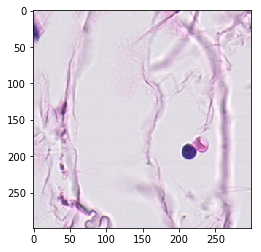

In [18]:
patch = get_patch2(slide, *random.choice(normal))
plt.imshow(patch)

divide into 30 parts to train

In [0]:
batch1 = slice(0, 2000)
#list(loc_tumor)[batch1]

In [19]:
# batch 1
batch1 = slice(0, 2000)
images = []
labels = []
for i, loc in enumerate(list(loc_tumor)[batch1]):
  patch = get_patch2(slide, *loc, 299, 299, 4)
  images.append(patch)
  labels.append(1)
  if i % 100 == 0: print('processing {:<2f}%'.format(100 *(i + 1) / len(list(loc_tumor)[batch1]) ))
for i, loc in enumerate(list(normal)[batch1]):
  patch = get_patch2(slide, *loc, 299, 299, 4)
  images.append(patch)
  labels.append(0)
  if i % 100 == 0: print('processing {:<2f}%'.format(100 *(i + 1) / len(normal[batch1]) ))
images = np.array(images)    
labels = np.array(labels)

processing 0.050000%
processing 5.050000%
processing 10.050000%
processing 15.050000%
processing 20.050000%
processing 25.050000%
processing 30.050000%
processing 35.050000%
processing 40.050000%
processing 45.050000%
processing 50.050000%
processing 55.050000%
processing 60.050000%
processing 65.050000%
processing 70.050000%
processing 75.050000%
processing 80.050000%
processing 85.050000%
processing 90.050000%
processing 95.050000%
processing 0.050000%
processing 5.050000%
processing 10.050000%
processing 15.050000%
processing 20.050000%
processing 25.050000%
processing 30.050000%
processing 35.050000%
processing 40.050000%
processing 45.050000%
processing 50.050000%
processing 55.050000%
processing 60.050000%
processing 65.050000%
processing 70.050000%
processing 75.050000%
processing 80.050000%
processing 85.050000%
processing 90.050000%
processing 95.050000%


In [0]:
features = conv_base.predict(images)

In [22]:
train_features = np.reshape(features, (len(features), -1))
history = model.fit(train_features, labels, epochs=20, batch_size=128, validation_split=0.2)

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 3s 924us/sample - loss: 4.6476 - acc: 0.7284 - val_loss: 2.0193 - val_acc: 0.7325
Epoch 2/20
3200/3200 [==============================] - 2s 538us/sample - loss: 0.9950 - acc: 0.7831 - val_loss: 1.1777 - val_acc: 0.6162
Epoch 3/20
3200/3200 [==============================] - 2s 537us/sample - loss: 0.5368 - acc: 0.8178 - val_loss: 0.8270 - val_acc: 0.6500
Epoch 4/20
3200/3200 [==============================] - 2s 523us/sample - loss: 0.4379 - acc: 0.8306 - val_loss: 0.9568 - val_acc: 0.5825
Epoch 5/20
3200/3200 [==============================] - 2s 534us/sample - loss: 0.3995 - acc: 0.8450 - val_loss: 1.0236 - val_acc: 0.5512
Epoch 6/20
3200/3200 [==============================] - 2s 520us/sample - loss: 0.3645 - acc: 0.8572 - val_loss: 0.4866 - val_acc: 0.7975
Epoch 7/20
3200/3200 [==============================] - 2s 518us/sample - loss: 0.3413 - acc: 0.8612 - val_loss: 0.7643 - val

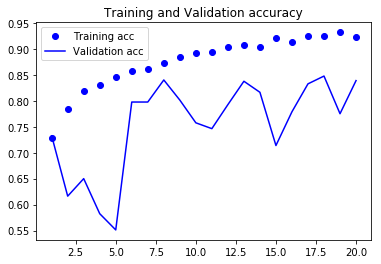

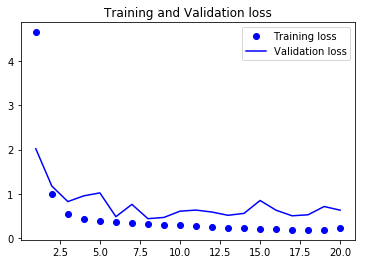

In [23]:
plot_history(history)

In [0]:
model.save('model_second0-2000.h5')
!cp 'model_second0-2000.h5' '/content/gdrive/My Drive/DeepLearning/datasets/DL_final/models/model_second0-2000.h5'

In [0]:
# free memory
import gc
del images
del labels
del features
del train_features

In [0]:
def _train_on_batch(batch_size=2000)